<a href="https://colab.research.google.com/github/mitul01/FER/blob/main/TransferLearning_ResNet50_oversampling_smoothLabels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
cd /content/drive/MyDrive/colab-20210303T131708Z-001/colab

/content/drive/MyDrive/colab-20210303T131708Z-001/colab


In [3]:
def make_6_emotions(df):
  for i in range(len(df)):
    if df['emotion'][i]==1:
      df['emotion'][i]==0
    elif df['emotion'][i]>1:
      df['emotion'][i]-=1
  return df

In [4]:
data = pd.read_csv('fer2013/fer2013.csv')
data= make_6_emotions(data)
train_data = data[data.Usage=='Training']
val_data = data[data.Usage=='PublicTest']
test_data = data[data.Usage=='PrivateTest']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Oversampling the data 

In [5]:
import collections
import imblearn
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
collections.Counter(train_data.emotion)

Counter({0: 3995, 1: 4533, 2: 7215, 3: 4830, 4: 3171, 5: 4965})

In [7]:
from keras.utils import to_categorical

x_train, y_train = oversampler.fit_resample(train_data.pixels.values.reshape(-1,1),train_data.emotion.values)

x_val = val_data.pixels.values.reshape(-1,1)
y_val = val_data.emotion.values

x_test = test_data.pixels.values.reshape(-1,1)
y_test = test_data.emotion.values

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [8]:
collections.Counter(y_train)

Counter({0: 7215, 1: 7215, 2: 7215, 3: 7215, 4: 7215, 5: 7215})

In [9]:
x_train = list(x_train)
x_val   = list(x_val)
x_test  = list(x_test)

for i,item in enumerate(x_train):
    x_train[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
for i,item in enumerate(x_val):
    x_val[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
for i,item in enumerate(x_test):
    x_test[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
    
x_train = np.vstack(x_train).reshape(-1,48,48,1)
x_val = np.vstack(x_val).reshape(-1,48,48,1)
x_test = np.vstack(x_test).reshape(-1,48,48,1)

In [10]:
y_train = to_categorical(y_train,num_classes=6)
y_val   = to_categorical(y_val  ,num_classes=6)
y_test  = to_categorical(y_test ,num_classes=6)

# Label Smoothing

In [11]:
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
    y2 = copy(y)
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y2 *= 1 - smooth_factor
        y2 += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y2

In [12]:
from keras.utils import Sequence
from keras.applications.resnet50 import preprocess_input
import cv2
from math import floor

class data_sequence(Sequence):
    '''
      yield sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
    '''
    def __init__(self, features, labels, batch_size=128, target_dim=(224,224), 
                 n_classes=6, shuffle=True, smooth=0.0):
        'Initialization'
        assert len(features)==len(labels), 'number of feature and labels not consistent'
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.target_channels = 3
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.smooth = smooth
        self.sample_count = len(labels)
        self.indexes = np.arange(self.sample_count)
        self.on_epoch_end()
#         self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return floor(self.sample_count / self.batch_size)

    def __gray2RGB__(self,x):
      if len(x.shape)==2:
        return np.stack((x,x,x),-1)
      else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
      return x


    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
        Y = np.empty((self.batch_size, self.n_classes))
        for i,ind in enumerate(indexes):
          x = self.features[ind]
          # resize image to the target size 
          x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)
          x = self.__gray2RGB__(x)
          X[i] = preprocess_input(x) # or version=2 for VGGFace2 ResNet50  
          y = self.labels[ind]
          if isinstance(y,int):
            Y[i]=to_categorical(y,6)
          else:
            assert len(y)==self.n_classes
            Y[i]=y
        X = np.array(X)
        Y = np.array(Y)
        if self.smooth > 0.0:
          smooth_labels(Y, self.smooth)
        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [24]:
train_sequence.

In [13]:
train_sequence = data_sequence(x_train,y_train,batch_size=16,target_dim=(224,224),n_classes=6,shuffle=False)
feature,lable = train_sequence.__getitem__(0)

In [14]:
emotion_dict = {0: 'Angry',1: 'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5:'Neutral'}

In [15]:
!pip install keras-vggface
!pip install keras_applications
from keras_vggface.vggface import VGGFace

     |████████████████████████████████| 51kB 6.9MB/s 


In [16]:
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))
vggface.trainable = False
vggface.summary()

94699520/94694792 [==============================] - 1s 0us/step
Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________

In [17]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

# model = Sequential([vggface,
#                     Flatten(),
#                     Dropout(0.5),
#                     BatchNormalization(),
#                     Dense(128, activation='relu'),
#                     Dropout(0.5),
#                     BatchNormalization(),
#                     Dense(len(emotion_dict), activation='softmax', name = 'classifer')])
model = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(6, activation='softmax', name = 'classifer')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classifer (Dense)            (None, 6)                 6

In [18]:
train_sequence = data_sequence(x_train,y_train,batch_size=64,target_dim=(224,224),n_classes=6,shuffle=True,smooth=0.07)
val_sequence   = data_sequence(x_val,  y_val,  batch_size=64,target_dim=(224,224),n_classes=6,shuffle=True,smooth=0.0)
test_sequence  = data_sequence(x_test, y_test, batch_size=64,target_dim=(224,224),n_classes=6,shuffle=True,smooth=0.0)

#train_sequence = data_sequence(x_train,y_train,batch_size=32,target_dim=(224,224),n_classes=6,shuffle=True,smooth=0.07)
#val_sequence   = data_sequence(x_val,  y_val,  batch_size=32,target_dim=(224,224),n_classes=6,shuffle=True,smooth=0.0)
#test_sequence  = data_sequence(x_test, y_test, batch_size=32,target_dim=(224,224),n_classes=6,shuffle=True,smooth=0.0)

In [19]:
EPOCHS=100

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint

model.compile(optimizer = Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

hist = model.fit_generator(generator = train_sequence,
                           validation_data = val_sequence,
                           callbacks=callbacks,
                           epochs = EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
676/676 [==============================] - 161s 186ms/step - loss: 1.9829 - accuracy: 0.4676 - val_loss: 1.0492 - val_accuracy: 0.5921
Epoch 2/100
676/676 [==============================] - 126s 187ms/step - loss: 0.9875 - accuracy: 0.6292 - val_loss: 1.0125 - val_accuracy: 0.6130
Epoch 3/100
676/676 [==============================] - 126s 187ms/step - loss: 0.8551 - accuracy: 0.6778 - val_loss: 0.9763 - val_accuracy: 0.6409
Epoch 4/100
676/676 [==============================] - 126s 187ms/step - loss: 0.7426 - accuracy: 0.7234 - val_loss: 1.0502 - val_accuracy: 0.6211
Epoch 5/100
676/676 [==============================] - 126s 186ms/step - loss: 0.6479 - accuracy: 0.7610 - val_loss: 1.0127 - val_accuracy: 0.6515
Epoch 6/100
676/676 [==============================] - 126s 186ms/step - loss: 0.5859 - accuracy: 0.7871 - val_loss: 1.0297 - val_accuracy: 0.6551
Epoch 7/100
676/676 [==============================] - 126s 186ms/step - loss: 0.5100 - accuracy: 0.8187 - val_loss: 1

In [20]:
model.evaluate(test_sequence)

56/56 [==============================] - 10s 172ms/step - loss: 1.5496 - accuracy: 0.6945


[1.5495702028274536, 0.6944754719734192]

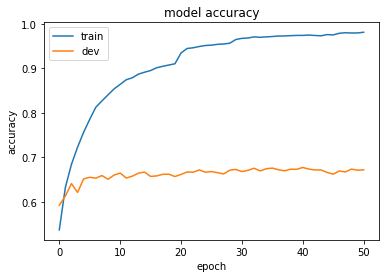

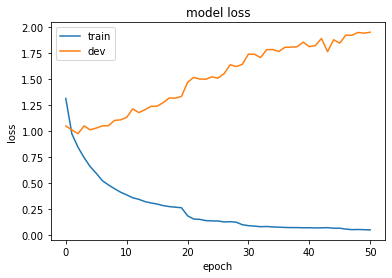

In [21]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [22]:
model.save('TransferLearning_ResNet50_oversampling_smoothLabels.h5')